# Setup

In [7]:
import numpy as np
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

## Load the data

Assumption: All the `n` images lie in the specified `folder` and are named `image_<idx>` with consecutive indices (consisting of three digits, optionally with prepended zeros).

In [2]:
n = 40
folder = '../data/images_train/'
images = np.stack(list(map(lambda index: np.load(f'{folder}/image_{index:03d}.npy'), range(n))))

number_of_images = images.shape[0]
channels = images.shape[1]
height = images.shape[2]
width = images.shape[3]

print(f"Number of images: {number_of_images}\nChannels: {channels}\nHeight: {height}\nWidth: {width}")

Number of images: 40
Channels: 10
Height: 1024
Width: 1024


# Apply the Model

In [3]:
cnn = load_model('../models/cnn')
cnn.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 5, 5, 20)          1820      
                                                                 
 flatten_22 (Flatten)        (None, 500)               0         
                                                                 
 dropout_35 (Dropout)        (None, 500)               0         
                                                                 
 dense_64 (Dense)            (None, 10)                5010      
                                                                 
 dense_65 (Dense)            (None, 1)                 11        
                                                                 
Total params: 6,841
Trainable params: 6,841
Non-trainable params: 0
_________________________________________________________________


In [4]:
def get_neighborhood(image, x, y):
    neighborhood = image[:,x:x+7, y:y+7,:]
    return neighborhood

In [5]:
batch_size = 1024  # One row is one batch
batch_counter = 0
X_batch = np.zeros((batch_size, 7, 7, 10))

for i in range(5, 6):
    predictions = []
    X_test = images[i]
    X_test = np.moveaxis(X_test, 0, -1)
    X_test = X_test[np.newaxis, :]

    X_test_padded = np.pad(X_test, ((0, 0), (3, 3), (3, 3), (0, 0)), mode='edge')

    for y in range(height):
        for x in range(width):
            X_new = get_neighborhood(X_test_padded, x, y)
            mean = np.mean(X_new)
            std = np.std(X_new)
            # Normalize the patch
            X_new = (X_new - mean) / std
            X_batch[batch_counter] = X_new
            batch_counter += 1
            if (batch_counter >= batch_size):
                pred = cnn.predict(X_batch).flatten()
                batch_counter = 0
                predictions = np.append(predictions, pred)
    predictions = predictions.reshape((1, width, height)).swapaxes(1, 2)
    np.save(f'./CNN/prediction_{i:03d}.npy', predictions)
    print(f"Image {i} completed.")

32/32 [==============================] - 0s 3ms/step
Image 5 completed.


# Visualize the Predictions

## Visualize one Patch in Detail

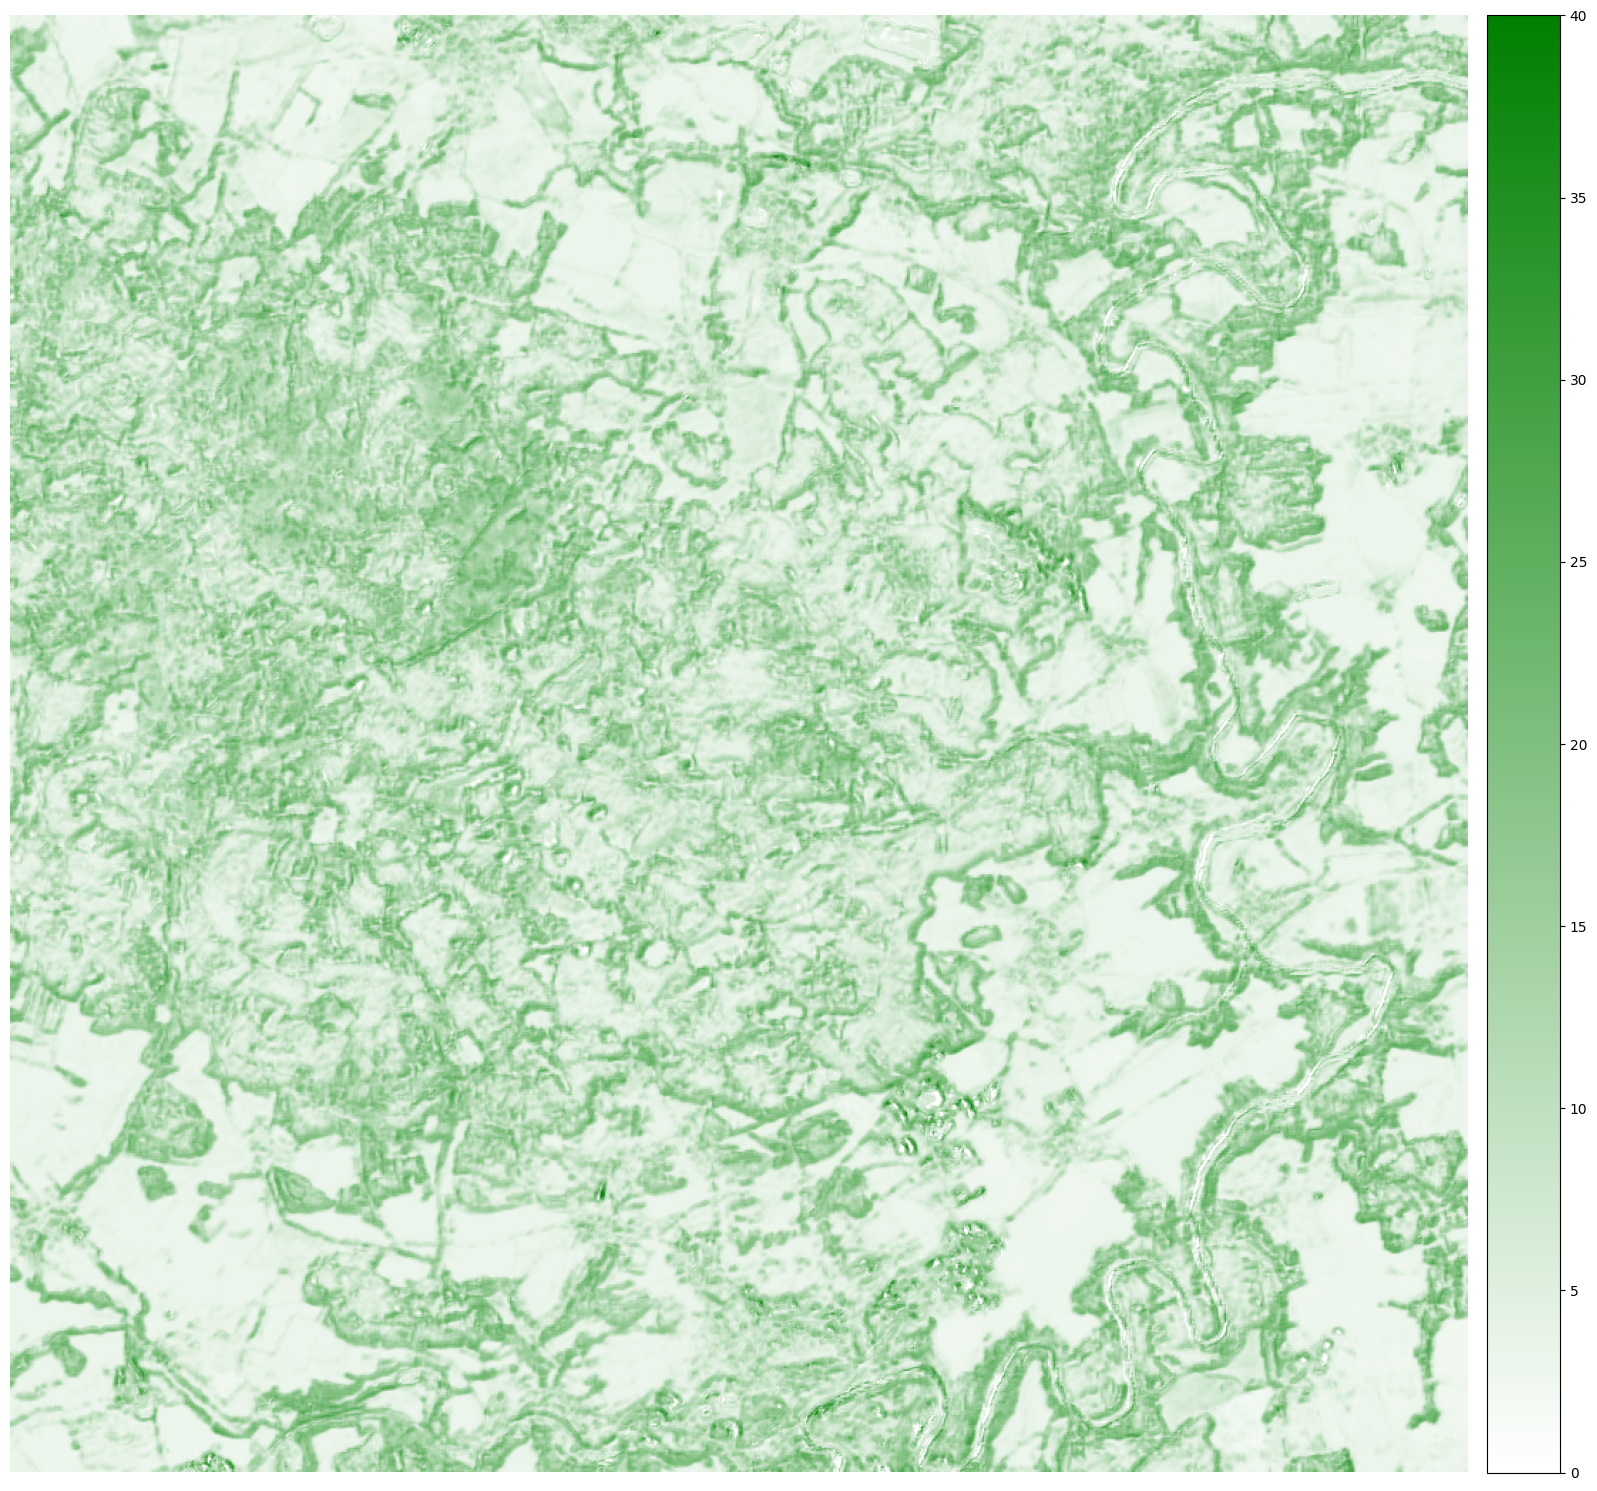

In [8]:
# Specify image index
i = 5

fig, ax = plt.subplots(figsize=(20, 20))
colors = ["white", "green"]
cmap = mcolors.LinearSegmentedColormap.from_list("mycmap", colors)
im = ax.imshow(np.load(f'./CNN/prediction_{i:03d}.npy')[0], cmap=cmap, vmin=0, vmax=40)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2)
plt.colorbar(im, cax=cax)

ax.axis('off')
plt.savefig(f'Train_{i}_CNN.png', bbox_inches='tight')
plt.show()